In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from H1Inpainting import H1Inpainting
from L2ParabolicInpainting import L2ParabolicInpainting
from LpAdjointMask import LpAdjointMask
from H1Mask import H1Mask
from FSHalftoning import FSHalftoning
from Thresholding import Thresholding
from Utils import Utils

# H1 Method

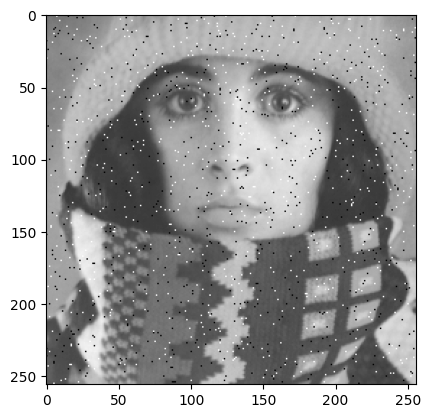

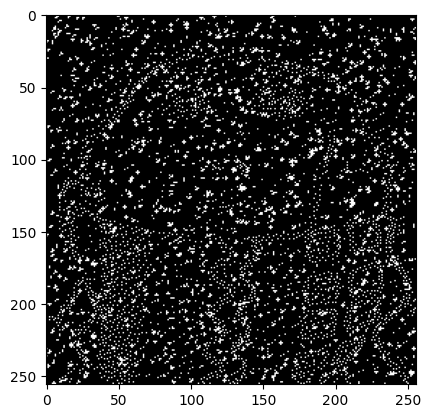

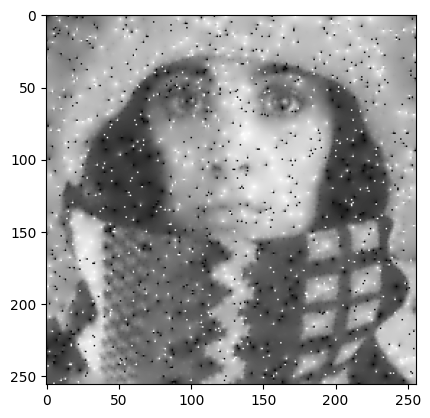

alpha=0.76 L1-error(u,f)=3097.18368873505 L1-error(u,fn)=2451.895415309961


In [5]:
alpha = 0.76
c = 0.1

# Open image
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applySPNoise(fOriginal, w, h, 0.01, 0.01, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

# Create Inpainting Mask
maskGenerator = H1Mask(w,h)
maskGenerator.setHalftoneMethod(FSHalftoning(w,h))
mask, f = maskGenerator.create(f, c)

plt.imshow(mask.reshape([h,w]), cmap='gray')
plt.show()

# Solve the Inpainting problem
InpaintingMethod = H1Inpainting(w,h)
InpaintingMethod.assemble(f, mask)
x = InpaintingMethod.process()

plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

print("alpha="+str(alpha)+" L1-error(u,f)="+str(Utils.L1Error(fOriginal,x,w,h))+" L1-error(u,fn)="+str(Utils.L1Error(f,x,w,h)))

Utils.saveGrayscaleImage(x, w, h, "x.png")

# L2 Method

# L1-ADJ Method

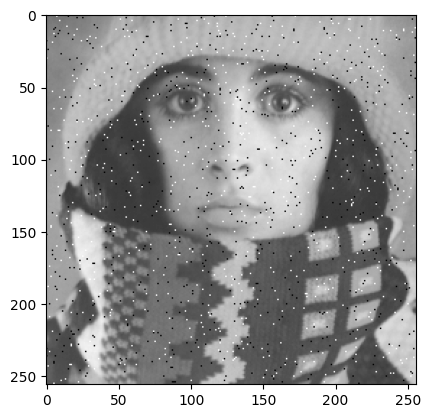

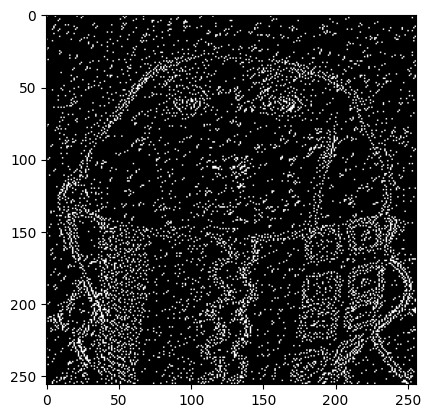

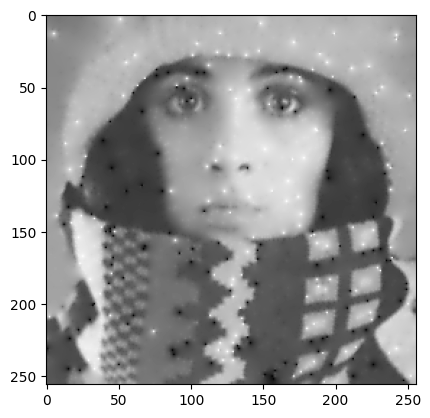

alpha=0.76 L1-error(u,f)=1325.8235212198792 L1-error(u,fn)=1787.6409702592266


In [2]:
alpha = 0.76
p = 1.01
c = 0.1

# Open image
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applySPNoise(fOriginal, w, h, 0.01, 0.01, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

# Create Inpainting Mask
maskGenerator = LpAdjointMask(w,h)
maskGenerator.setAlpha(alpha)
maskGenerator.setP(p)
maskGenerator.setHalftoneMethod(FSHalftoning(w,h))
mask, f = maskGenerator.create(f, c)

plt.imshow(mask.reshape([h,w]), cmap='gray')
plt.show()

# Solve the Inpainting problem
InpaintingMethod = H1Inpainting(w,h)
InpaintingMethod.assemble(f, mask)
x = InpaintingMethod.process()

plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

print("alpha="+str(alpha)+" L1-error(u,f)="+str(Utils.L1Error(fOriginal,x,w,h))+" L1-error(u,fn)="+str(Utils.L1Error(f,x,w,h)))

Utils.saveGrayscaleImage(x, w, h, "x.png")

# L2-ADJ Method

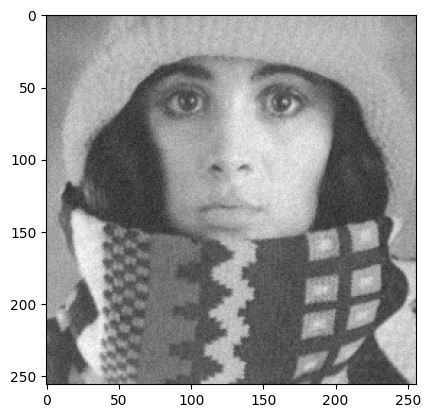

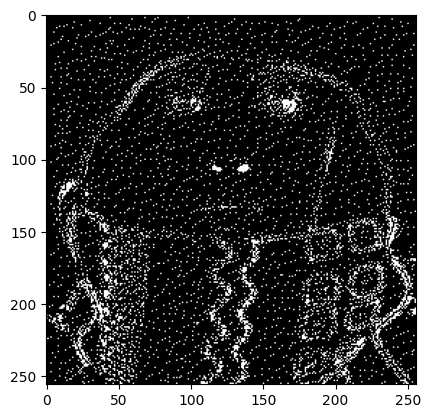

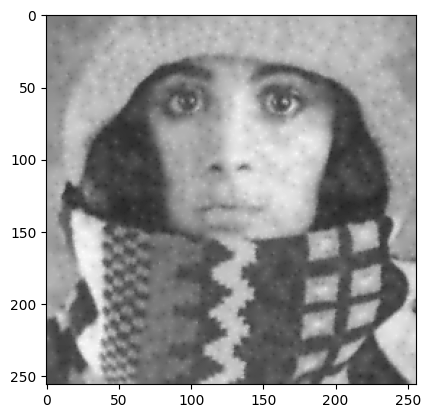

alpha=0.96 L2-error(u,f)=7.961443834329059 L2-error(u,fn)=9.61446503090544


In [4]:
alpha = 0.96
p = 2
c = 0.1

# Open image
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applyWhiteNoise(fOriginal, w, h, 0.03, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

# Create Inpainting Mask
maskGenerator = LpAdjointMask(w,h)
maskGenerator.setAlpha(alpha)
maskGenerator.setP(p)
maskGenerator.setHalftoneMethod(FSHalftoning(w,h))
mask, f = maskGenerator.create(f, c)

plt.imshow(mask.reshape([h,w]), cmap='gray')
plt.show()

# Solve the Inpainting problem
InpaintingMethod = H1Inpainting(w,h)
InpaintingMethod.assemble(f, mask)
x = InpaintingMethod.process()

plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

print("alpha="+str(alpha)+" L2-error(u,f)="+str(Utils.L2Error(fOriginal,x,w,h))+" L2-error(u,fn)="+str(Utils.L2Error(f,x,w,h)))

Utils.saveGrayscaleImage(x, w, h, "x.png")

# Numerical Results

## Salt and Pepper Noise

## Gaussian Noise